# Regression

## *Workshop 7*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W07.%20Linear%20Regression.ipynb)

### Aims:

In this workshop, we're going to be modeling the relationship between education and income. More precisely, we're going to be looking at the effect of increasing education on hourly wages using Ordinary Least Squares regression. We're going to accomplish this in four steps:

1. Summary Statistics
    * Table of Summary Statistics
2. Visualisation
    * Exploratory Plots
3. Assumptions
    * A. Independence
    * B. Heteroscedasticity: Regression plots + Q-Q plot
    * C. Multicollinearity: VIF + Correlation Matrix
4. Regression
    * Regression Table

If you're conducting a regression, you must complete the steps above, and produce each item indicated by a bullet point.

## Getting Started


As always we'll start by importing the libraries I need

In [1]:
#This tells python to draw the graphs "inline" - in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np
# make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")



Now that I've imported the libraries I'm going to be using, I'm ready to import the data:

In [2]:
df=pd.read_csv('https://storage.googleapis.com/qm2/wk7/cps.csv')
df.head()

,year,state,age,sex,race,sch,ind,union,incwage,realhrwage,occupation
0,1990,36,58,1,3,12.0,871,0.0,14200.0,12.269874,Office and Admin Support
1,2009,5,28,1,1,12.0,8660,1.0,17680.0,8.635149,Office and Admin Support
2,1990,36,37,1,1,14.0,380,1.0,28000.0,21.169851,.
3,1990,6,34,1,1,18.0,740,1.0,27500.0,20.447746,Computer and Math Technicians
4,1981,51,38,1,4,13.0,798,NaN,17000.0,18.892282,Managers


Our dataframe has 10 columns:

1. *year*: Survey year
2. *age*: the person's age
3. *sex*: the person's sex
    * 1=male
    * 2=female
4. *race*: the person's race
    * White non hispanic=1
    * Black non hispanic=2
    * Hispanic=3
    * Other non hispanic=4)
5. *sch*: Educational attainment
    * None = 0,
    * Grades 1-12 = 1-12
    * Some University = 13,
    * Associate's degree = 14,
    * BA = 16
    * Advanced Degree = 18
6. *union*: Union membership
    * N/A = 0,
    * No union coverage = 1,
    * Member of labor union=2,
    * Covered by union but not a member=3
7. *incwage*: Wage and salary income
8. *realhrwage*: Real Hourly Wage
9. *occupation*: Occupation
10. *ind*: [industry code](https://www.census.gov/naics/?58967?yearbck=2002)
11. *state*: [FIPS code](https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm) denoting the state of residence.

We'll begin, as we did with last week's workshop, by selecting the year 2013 in our data and making sure that all the variables that represent categories are stored as categorical in python:

In [3]:
reg_df=df[df['year']==2013].drop(['year'],axis=1) # filter the whole dataset to 2013 and drop year column
reg_df[['race','union','sex','occupation','ind','state']]=reg_df[['race','union','sex','occupation', 'ind','state']].astype('category') # convert these columns to categorical

## 1. Summary Statistics

Once our data has been cleaned and all our variables are stored as the appropriate type, we can start with the first step of any regression project: creating a table of summary statistics. This is an important part of the process, since it gives the reader a qualitative understanding of your data before you analyze it. It also serves to demonstrate that you've cleaned the data appropriately, and that the measures of the variables make sense.

In [4]:
summary=reg_df.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
age,53790.0,42.91,10.56,25.00,34.00,43.00,51.00,64.0
sch,53790.0,13.93,2.74,0.00,12.00,13.00,16.00,18.0
incwage,53790.0,51821.86,60163.45,38.00,24000.00,40000.00,63000.00,1102999.0
realhrwage,53790.0,24.38,151.90,2.01,12.17,18.44,28.12,34760.8


This table is already informative. I now know that the average person in this dataset is 42 years old, has around 14 years of schooling, and makes $24/hour (or $51,821/year). However, it's also useful to spot potential errors in data entry that may warrant greater attention.

Notice the max value for real hourly wage. Despite the fact that those in the top 75% of earners make $28.12/hour, someone is making $34,760 per hour. Must be nice (or, may be a data entry error). Either way, because regresisons are sensitive to this sort of outlier, we should remove it. I've defined a function below that calculates the quartiles and filters out observations that are more than three times as far away form the top quartile as the top quartile is from the bottom one. This was a somewhat arbitrary choice, but it allows me to be consistent if I want to apply it to other variables. You could also just pick a cutoff qualitatively and justify it (e.g. "I will focus on those making up to $250k per year, since they represent the population i'm trying to understand").   

In [5]:
def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 3*iqr # calculate the lower bound
    high = q3 + 3*iqr # calculate the upper bound
    filtered = reg_df[(var > low) & (var < high)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

reg_df=filter_outliers(reg_df['realhrwage']) # filter outliers from realhrwage


Dropped 1040 observations


We can see that this operation dropped 1040 observations that had extreme values in the "realhrwage" variable. Let's re-generate the table of summary statistics and only keep four columns: count, mean, standard deviaiton, minimum, and maximum.

In [6]:
summary=reg_df.describe().round(2).T
summary[['count','mean','std','min','max']]


,count,mean,std,min,max
age,52750.0,42.84,10.57,25.00,64.00
sch,52750.0,13.88,2.73,0.00,18.00
incwage,52750.0,46849.39,33376.96,38.00,353000.00
realhrwage,52750.0,21.59,13.03,2.01,75.81


## 2. Visualization

The summary statistics table provides us with a good overview of some of the variables we're interested in. However, you'll notice that it omits many of the other variables in our dataset: the categorical ones. This is because calculating the mean, standard deviation, etc. of something like the "occupation" column doesn't really make sense. For that, we turn to visualization.

### Visualizing the distribution of categorical variables

So far in this course we've been using a python library called Matplotlib to make our visualizations, which we've been calling using the 'plt' alias. But this isn't the only one that is avaialble to us. [Seaborn](https://seaborn.pydata.org/) is another library that has some cool plotting functions that are more geared towards statistical analysis. We've already imported seaborn above, and we'll be calling it using the alias "sns". We can use it in conjunction with matplotlib.

To get a sense of the distribution of our categorical variables, we'll make some plots that count the number of observations in each category. Let's start with the race category:

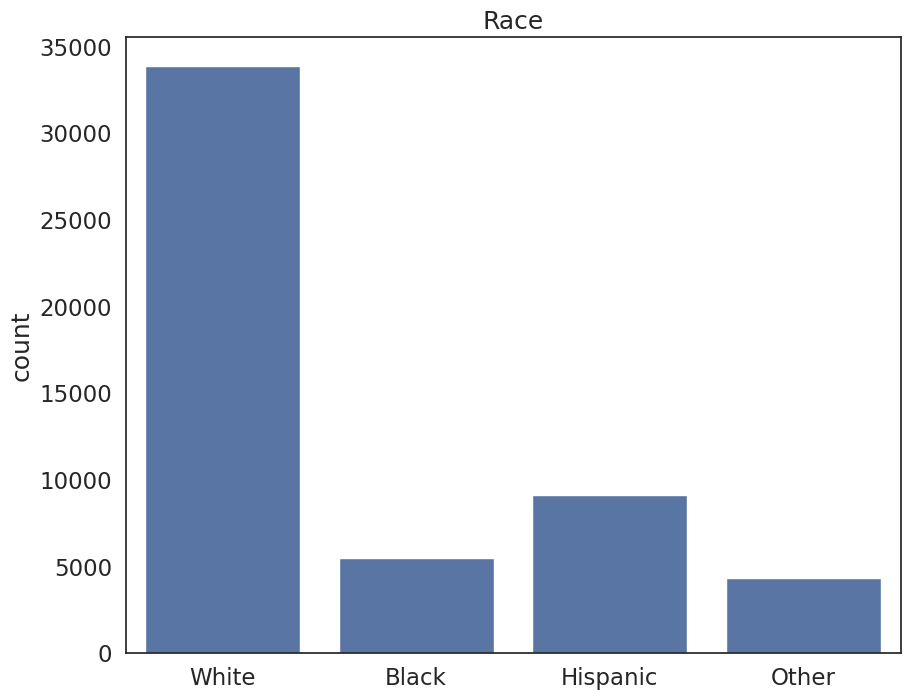

In [7]:
sns.countplot(data=reg_df, x='race') # plot the union variable

plt.title('Race') # add a title
plt.xlabel('') # remove the x axis label
plt.xticks(ticks=[0,1,2,3],labels=['White', 'Black','Hispanic','Other']) # replace the x axis labels with more descriptive labels
plt.show() # show the plot


### Exercise

1. Generate an equivalent plot for the other categorical columns
2. What is the most common industry code, and what does it correpsond to?


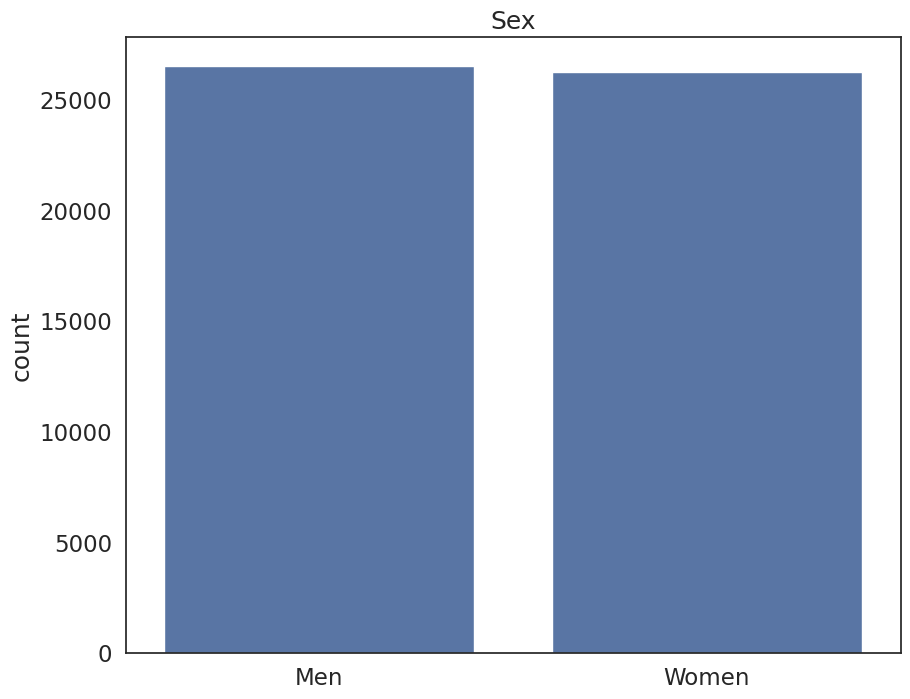

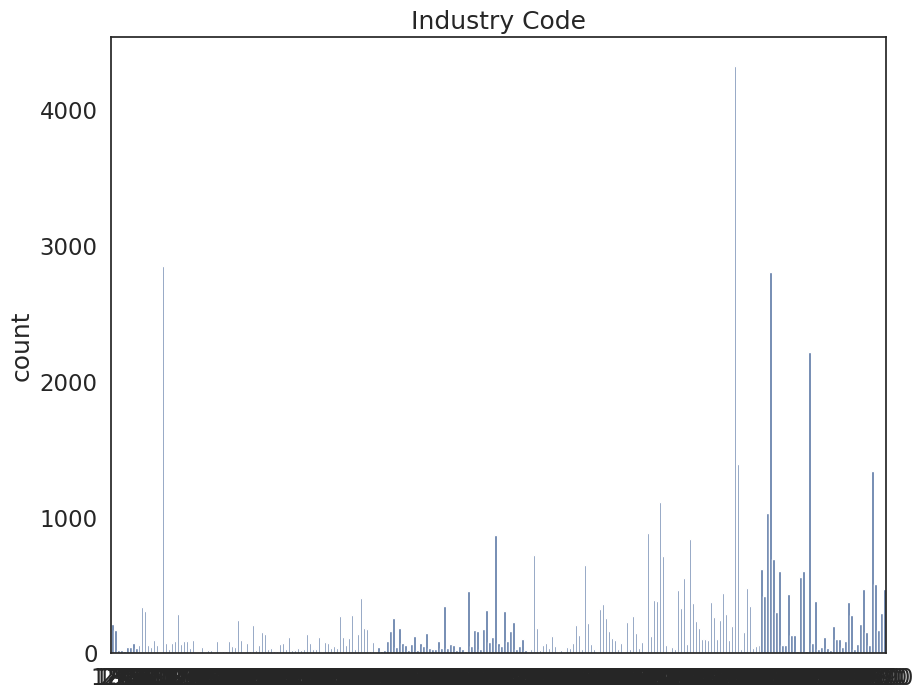

,ind
0,7860


In [8]:
sns.countplot(data=reg_df, x='sex') # plot the union variable

plt.title('Sex') # add a title
plt.xlabel('') # remove the x axis label
plt.xticks(ticks=[0, 1],labels=['Men', 'Women']) # replace the x axis labels with more descriptive labels
plt.show() # show the plot

sns.countplot(data=reg_df, x='ind') # plot the union variable
plt.title('Industry Code') # add a title
plt.xlabel('') # remove the x axis label
plt.show() # show the plot)

mode_industry_code = reg_df['ind'].mode()
mode_industry_code

The most common industry code is 7860.  This corresponds to the business's main area of economic activity that is categorized by the number 7860

## 3. Assumptions

Once you've generated summary statistics for your continuous variables and exploratory plots for the categorical ones, it's time to start thinking about the relationships *between* the variables. Today, we're going to be modeling a linear relationship between income and years of schooling, by means of a **linear regression**. But before we do that, we need to check a couple things-- all statistical tests have a number of assumptions that must be satisfied in order to yield robust results. Before we run a regression, we must check that the assumptions in this case are satisfied. There are four main ones:

    A. Indepdendence
    B. Homoscedasticity
    C. Multicollinearity

Let's go through them one by one.

### A. Independence

**`Linear regression assumes that measurements for each sample subject are in no way influenced by or related to the measurements of other subjects.`**

Though in the full CPS dataset we have repeat observations of the same individual over time, we've only been analyzing one year's worth of data, so we satisfy the independence assumption. If we ran a regression on the full sample over multiple years, *this would violate the independence assumption*. It's very possible to run a regression with repeat observations of the same units (people, places, etc.) over time, but you need to use a special type of regression called a **panel regression**. More on that next week.

### B. Homoscedasticity

**`Linear regression assumes that the variance of residuals is the same for any value of x, and that residuals are normally distributed with a mean of 0.`**

This is a complicated way of saying your regression line should fit consistently across the full range of $x$ values. If there are really small residuals (i.e., all the data points are close to the line) for low values of $x$, but larger residuals for high values of $x$, the regression is not performing well-- we wouldn't have the same confidence in our predictions at different values of $x$. Similarly, if all the residuals are on one side of the regression line in different parts of the $x$ range, the model will consistently over/underestimate in those regions. When the variance of residuals from a regression model are inconsistent, we have **`Heteroscedasticity`**.

We can explore potential heteroscedasticity by visually inspecting a regression plot. In our case, we're primarily interested in the relationship between years of schooling and hourly wages, so we'll be plotting these variables against eachother. `sns.jointplot()` lets us create a plot with four components which can help us diagnose potential heteroscedasticity:

- The main plot is a scatterplot between hourly wages on the y axis, and years of schooling on the x axis.
- A regression line overlaid on this plot lets us see the relationship between our model and the underlying data
- A histogram to the right of the plot shows the distribution of the hourly wages variable, which is heavily skewed.
- A histogram above the plot shows the distribution of the years of schooling variable, which has an almost bimodal form.   

Text(69.75, 0.5, 'Hourly Wage')

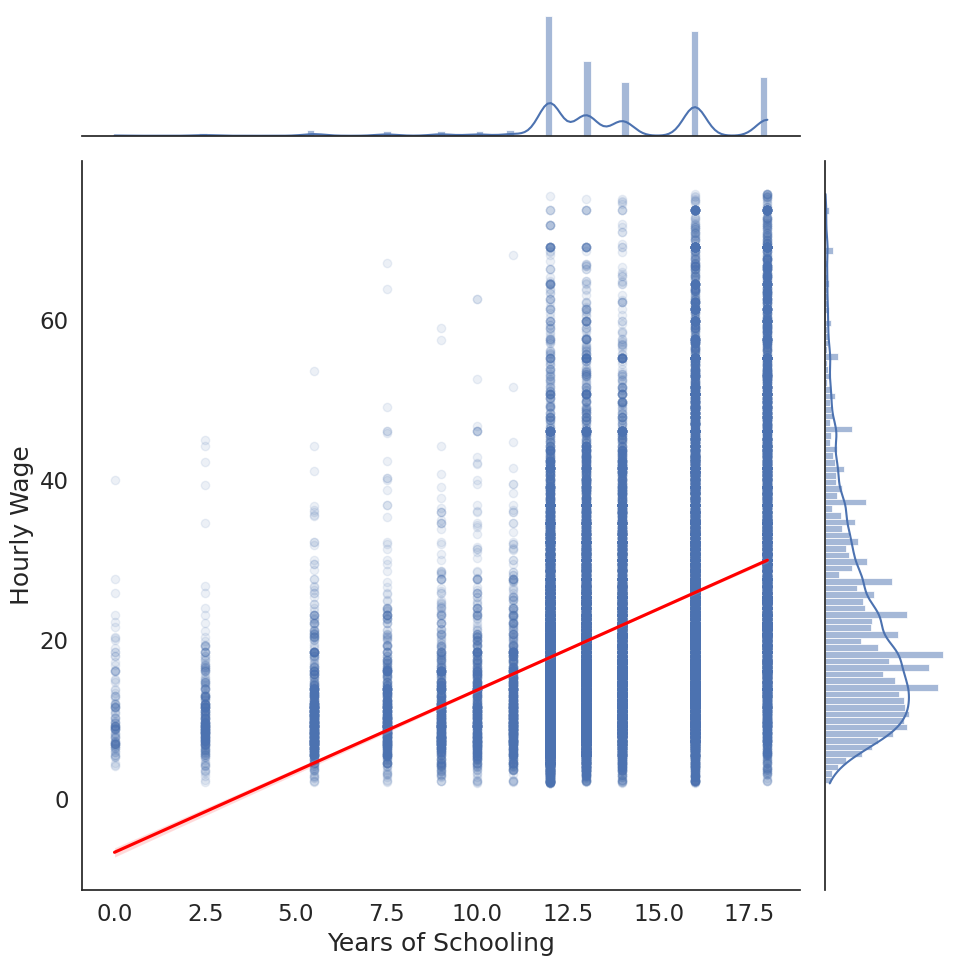

In [9]:
sns.jointplot(data=reg_df, # plot a scatterplot with a regression line and two histograms
                x='sch', # set the x axis to be the years of schooling
                y='realhrwage', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Years of Schooling') # add a label to the x axis
plt.ylabel('Hourly Wage') # add a label to the y axis

The plot above is cause for concern. From 0 to 5 years of schooling the model has underestimated hourly wages for every single observation. Conversely, at the far right tip of the regression line, we can see that the model *overestimates* income for many individuals with 18 years of schooling. This gives us reason to suspect that there may be asymmetry in the residuals of our model (heteroscedasticity). We're going to fix this in the Exension section below. But for now, let's proceed.

### C. Multicollinearity

**`Multicollinearity emerges when two or more independent variables which are highly correlated are included in a model.`** A key goal of regression analysis is to isolate the relationship between each independent variable and the dependent variable. The interpretation of a regression coefficient is that it represents the mean change in the dependent variable for each 1 unit change in an independent variable when you hold all of the other independent variables constant.

The idea is that you can change the value of one independent variable and not the others. However, when independent variables are correlated, it indicates that changes in one variable are associated with shifts in another variable. The stronger the correlation, the more difficult it is to change one variable without changing another. See this [blog post](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/) for a thorough explanation.

One way of visually exporing multicollinearity is through a correlation matrix:

Text(0.5, 1.0, 'Correlation Matrix')

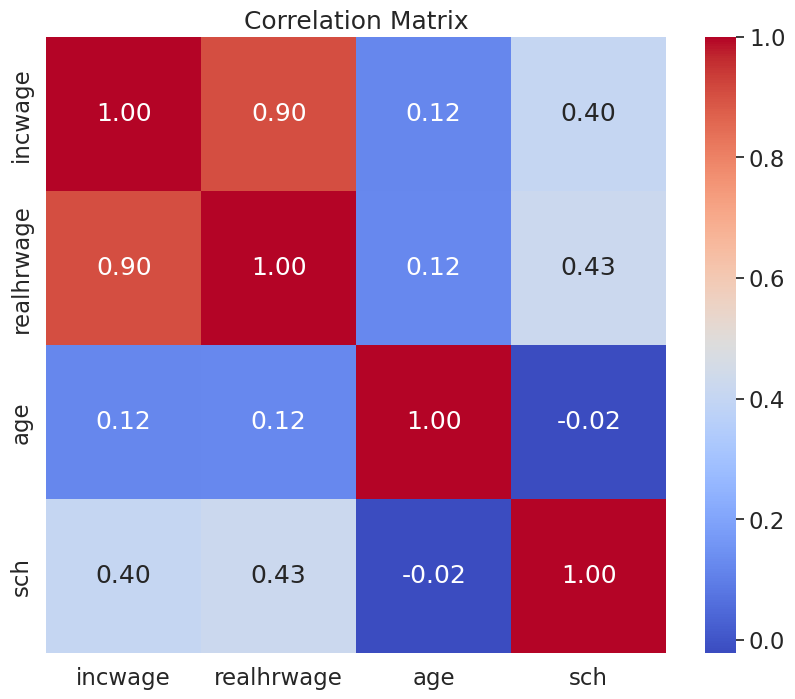

In [10]:
sns.heatmap(reg_df[['incwage','realhrwage','age','sch']].corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

This matrix has each of the continuous variables in `reg_df` on both axes. Each cell denotes the correlation between the corresponding variables. Naturally, on the diagonal we have a series of perfect correlations (1.00), as each variable is perfectly correlated with itself. `incwage` (annual salary) and `realhrwage` (hourly wage) are highly correlated with each other, which makes a lot of sense. This isn't a concern for multicollinearity, though, since `realhrwage` will be our dependent variable. This type of correlation matrix is also a good way of conducting exploratory data analysis-- we can already see that the next-highest set of correlations is between years of schooling and both hourly wages and annual salary.

Though a very high correlagtion coefficient between independent variables is a cause for concern, the formal way of dealing with muticollinearity is through the use of the **`Variance Inflation Factor (VIF)`**. VIF is the ratio of the variance in a model with multiple predictors by the variance of a model with a single predictor:

$$\large VIF_j=\frac{1}{1-R_{j}^{2}}$$

VIFs start at 1 and have no upper limit. A value of 1 indicates that there is no correlation between this independent variable and any others. VIFs between 1 and 5 suggest that there is a moderate correlation, but it is not severe enough to warrant corrective measures. VIFs greater than 5 represent critical levels of multicollinearity where the coefficients are poorly estimated, and the p-values are questionable. More explanation of the theory can be found [here](https://en.wikipedia.org/wiki/Variance_inflation_factor).

Below is a function that calculates VIF for each independent variable in a dataframe, and drops them if they exceed a threshold (set to 5).

In [11]:
# calculating VIF
# This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

Now we can implement this on our dataset:

In [12]:
ind_vars=['sex','age','sch', 'union','race']

vif = drop_column_using_vif_(reg_df[ind_vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 1.0471509029112516
The columns remaining after VIF selection are:
Index(['sex', 'age', 'sch', 'union', 'race'], dtype='object')


The maximum VIF value encountered was 1.04-- well within the acceptable range. Accordingly, the function hasn't dropped any of the independent variables in our dataset.

Having explored our data through visualizations and summary statistics, and checked the assumptions of linear regression, we're now ready to begin building a model.

## 4. Regression

Remember, the Ordinary Least Squares (OLS) regression seeks to find a straight line that best describes the relationship between two variables:

$$y= \beta_0 + \beta_1x+\epsilon $$

In our case, we're trying to predict hourly income-- this is our **dependent variable**, and there can be only one per regression. The variable we're using to predict hourly income is years of schooling, which is our **independent variable**. We can have multiple of these per regression. As such, the regression equation in our scenario looks like this:

$$Hourly\ Income= \beta_0 + \beta_1 \times Years\ of\ Schooling +\epsilon $$

Because the regression model will estimate the parameters $\beta_0, \beta_1$ and $\epsilon$, we just need to supply python with $x$ and $y$; We can do so by passing `realhrwage ~  sch` to the `ols()` function from statsmodels. This will run a regression of the form specified above, which we will store in an variable called `model`. We can get the output from this model using `model.summary()`:

In [13]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

model= ols('realhrwage ~  sch', data=reg_df).fit() # fit the model
print(model.summary()) # print the summary


                            OLS Regression Results                            
Dep. Variable:             realhrwage   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                 1.164e+04
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:40:42   Log-Likelihood:            -2.0503e+05
No. Observations:               52750   AIC:                         4.101e+05
Df Residuals:                   52748   BIC:                         4.101e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.6246      0.266    -24.858      0.0

There's a lot going on in the regression output above. If you want a more detailed explanation of what each part means, check out this [blog post](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a). In practice, we only need to focus on a couple parts of this output:

* `R-squared`: This value tells the proportion of the variation in our dependent variable (realhrwage) that is explained by the model we fit. In this case we can interpret it as follows:
    * **18.1% of the variation in hourly wages can be explained by this regresion model**

* `coef`: These are our $\beta$ estimates; it is the slope of the regression line that describes the relationship between a given independent variable (sch) and the dependent variable (realhrwage). There are two coefficients listed under this
    * `sch`: This is $\beta_1$, the slope coefficient on the years of schooling variable. It tells us the change in $y$ that results from a 1-unit increase in $x$. In robotic terms, we can interpret it as follows:
        * **A 1 unit increase in `sch` leads to a 2.0327 increase in `realhrwage`**. But we are not robots, and both of these variables are in units that we can interpret in plain english. Here's a more natural interpretation:
        * **On average, every additional year of schooling is associated with a $2.03 increase in hourly wages.**

    * `Intercept`: This is $\beta_0$. It tells us the value of $y$ when all of the independent variables in the model are held at 0. In this case, it can be interpreted as
        * **According to our model, a person with 0 years of schooling is predicted to earn -$6.62 per hour**
        * Naturally, this is a nonsensical prediction. There are no jobs that pay negative wages. We'll examine why this is happening in the next section, when we look into the assumptions of linear regression.
    
    
* `P>|t|`: this is known as the "p-value", and is the main measure of statistical significance. **A p-value denotes the probability of obtaining a result at least as extreme as the one observed, assuming that the null hypothesis is true**. In the case of a regression, the null hypothesis is that there is no relationship between our variables-- increasing $x$ has no effect on $y$. In other words, that the regression line is flat: $\beta_1=0$ . A p-value of 0.05 means that the coefficient is statistically significant at the 5% level. In our case, the p-value is 0.000 (note: this doesn't mean it's equal to zero, just very very small), and we can therefore reject the null hypothesis that $\beta_1=0$ at the 1% confidence level. However, this isn't the end of the story-- remember our weird negative intercept, and the fact that our model explains less than 20% of the variation in hourly wages ($R^2=0.181$). For a good overview of what exactly a p-value is, and why we should be cautious when interpreting them, see this [journal article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6532382/).


### Categorical Variables

The results of our first regression seem to show that the more education a person has, the higher their hourly wage. This makes intuitive sense, but it's probably not the whole picture. We may also suspect that older people earn more, since they have more experience and are more senior. We've also seen i previous classes that there are significant disparities in income. Considering we have data on all these variables, we can set up the following model:

$$Hourly\ Income= \beta_0 + \beta_1 \times Years\ of\ Schooling + \beta_2 \times Age + \beta_3 \times Sex +\epsilon $$

When we convert this equation into the python equivalent, it will look like this:

`realhrwage ~  sch + age + C(sex)`

Notice that for the sex variable is put within `C()`. This is how we indicate that the variable in question is categorical, and that it should be treated differently. Unlike a continuous variable, we're not interested in the change in $y$ that results from a 1 unit increase in $x$, since our units have no meaningful order. Instead, we'll have to pick one of the categories (called a **base category**/**reference category**), and compare each of the other categories in that variable against this one. You can specify the base category explicitly (for example `realhrwage ~  sch + age + C(sex, Treatment(reference=2))` makes women the base category), or python will pick one for you. As such, for a categorical variable with $n$ categories, we get $n-1$ coefficeints which denote the change in $y$ associated with membership of a given category compared to the base category. For example, if we have a categorical variable with three levels $a, b, c$ where $a$ is the base category, we would get *two* coefficients: $\beta_1 b$ and $\beta_2 c$. Then we would interpret the resulting coefficient as

* "Compared to category $a$, membership of category $b$ is associated with a $\beta_1$ change in $y$."
* "Compared to category $a$, membership of category $c$ is associated with a $\beta_2$ change in $y$."

Let's see what this looks like in our regression output:

In [14]:
model = ols('realhrwage ~  sch + age + C(sex)', data=reg_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             realhrwage   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     5514.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:40:46   Log-Likelihood:            -2.0310e+05
No. Observations:               52750   AIC:                         4.062e+05
Df Residuals:                   52746   BIC:                         4.062e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -12.6722      0.330    -38.392      

We now have 4 coefficients. In general, we don't always have to interpret the Intercept coefficient. It's not really that meaningful in this case, since now it denotes the predicted hourly income of someone who is male, has 0 years of schooling, and is 0 years old. It's good to keep it in mind as a sense check, though. The rest of the coefficients can be interpreted as follows:

* `C(sex)[T.2]`: On average, women earn $5.2 less per hour than men.
    * [T.2] in this line denotes the category in this variable associated with the given coefficient. So this is telling us that what is being shown is the coefficient associated with membership of category 2 in the sex variable; based on the description of the variables above, we know that sex=1 indicates men, and sex=2 indicates women. Naturally, we don't see a coefficient for `C(sex)[T.1]`, because this is the *base category*.
* `sch`: Every additional year of schooling is associated with a $2.13 increase in hourly income
* `age`: Every additional year of age is associated with a $0.16 increase in hourly income

### Exercise

1. Estimate a regression of the following form and store the results in a variable called **model1**:

$$Hourly\ Income= \beta_0 + \beta_1 \times Years\ of\ Schooling + \beta_2 \times Age + \beta_3 \times Sex + \beta_4 \times Union\ Membership + \beta_5 \times Race +\epsilon $$

2. Intepret each of the coefficients appropriately. Make note of the statistical significance of each result, and comment on the overall fit of the model.


In [15]:
model1 = ols('realhrwage ~  sch + age + C(sex) + C(union) + C(race)', data=reg_df).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:             realhrwage   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1887.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:40:57   Log-Likelihood:            -2.0293e+05
No. Observations:               52750   AIC:                         4.059e+05
Df Residuals:                   52740   BIC:                         4.060e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.1138      0.358    -

Coefficient for:
  C(sex)[T.2] = -5.1971 suggests that women earn, on average, $5.20 less per hour than men. Statistically significant as p<0.001

  C(union)[T.1.0] = -0.6196 suggests that individuals with no union coverage earn approxiamtely $0.62 less than the reference group, men, on average. Statistically significant as p<0.001

  C(union)[T.2.0] = 1.5466 suggests that, on average, union memberes earn $1.55 more than men. Statistically significant as p<0.001

  C(union)[T.3.0] = -0.5854 suggests that individuals covered by a union but not union members earn approixametly $0.55 less, on average, than men. Not statistically significant as p >0.05.

  C(race)[T.2] = -2.6796 suggests that, on average, black non-hisoanic individuals earn $2.68 less per hour than white non-hispanic individuals. Statistically significant as p<0.001

  C(race)[T.3] = -1.2263 suggests that hispanic individuals earn, on average, $1.23 less per hour than white non-hispanic individuals. Statistically significant as p < 0.001

  C(race)[T.4] = 0.0009 suggests that, on average, there is virtually no difference in hourly wage between other non-hispanic individuals and white non-hispanic individuals. Not statistically significant as p > 0.05

  sch = 2.0706 suggests that each additional year of schooling is associated with a $2.07 increase in hourly wage, on average. Statistically significant as p < 0.001.

  age = 0.1655 suggests that each additional year in age is associated with a $0.17 increase in hourly wage, on average. Statistically significant as p < 0.001

### Creating a Regression Table

Now that we've got a good sense of how regressions work and how to interpret them, we need to communicate these results properly. Many of you have probably read journal articles in which regression results are reported, but I doubt you've ever seen the output of `model.summary()` copied and pasted in the text of an article. Instead, these results are reported following a fairly standardized convention: a regression table. It picks out the components of the model summary that we're interested in, and formats them in a consistent and easy-to-interpret way. Luckly, the statsmodels package has a function called `summary_col` that takes a fitted model and formats it for us automatically; we just need to tweak a few options.

In the example below, i'm going to run two regressions; one in which i filter the data to only include people from California, and another for people in Mississippi (the richest and poorest states, respectively), to see if the relationship between wages, sex, age, and schooling differ geographically. I'm then going to create a regression table in which each column is a different regression model, and row will contain the coefficient for a given independent variable with the standard error in parentheses underneath and the level of statistical significance (i.e., size of the p-value) denotes by stars such that: * p<0.05, ** p<0.01, *** p<0.001.

In [16]:
california = ols('realhrwage ~  sch + age + C(sex)', data=reg_df[reg_df['state']==6]).fit()  # fit a model to california-- i'm filtering the data using the FIPS code for california, which is 6
mississippi = ols('realhrwage ~  sch + age + C(sex)', data=reg_df[reg_df['state']==28]).fit()  # same thing for mississippi (FIPS code 28)

table=summary_col( # create a regression table
    [california,mississippi], # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=['California','Mississippi'], # set the name of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table)


               California Mississippi
-------------------------------------
Intercept      -12.136*** -10.111*** 
               (1.030)    (3.497)    
C(sex)[T.2]    -5.154***  -4.980***  
               (0.350)    (0.924)    
sch            2.096***   1.850***   
               (0.053)    (0.205)    
age            0.217***   0.115**    
               (0.017)    (0.045)    
R-squared      0.262      0.199      
R-squared Adj. 0.262      0.193      
N              5079       430        
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


This layout lets us clearly explore our regresison results. This lets us clearly compare the coefficients of the same variable in different models. For example, we can see that men tend to earn $5.15 more per hour than women in California, but just $4.98 more per hour in Mississippi, and both of these results are statistically significant at the 1% level. This suggests that the wage gap is actually somewhat higher in California! Why might this be?

### Exercise

$$ Hourly\ Income= \beta_0 + \beta_1 \times Years\ of\ Schooling + \beta_2 \times Age + \beta_3 \times Sex + \beta_4 \times Union\ Membership + \beta_5 \times Race +\epsilon $$

1. Run five regressions, each of the form above (same as earlier):
    * In the first model, run the regression on the full sample contained in `reg_df`. In subsequent modles, restrict the sample to the following professions:
        * Production
        * Farmers
        * Bankers
        * Doctors & Lawyers
2. Create a regression table containing the results of each model in a separate column
3. Interpret the coefficients on the union related variables
    * How does union membership affect hourly wages across different sectors?
    * How does the gender wage gap vary across sectors?

In [17]:
print(reg_df['occupation'].unique())

['.', 'Consruction, Extraction, Installation', 'Managers', 'Transportation and materials moving', 'Office and Admin Support', ..., 'Protective Service adj_occupations', 'Computer and Math Technicians', 'Farming, Fishing & Forestry', 'Business Operators', 'Lawyers, Judges,Physicans and dentists']
Length: 13
Categories (13, object): ['.', 'Business Operators', 'Community and Social Workers',
                          'Computer and Math Technicians', ..., 'Production', 'Protective Service adj_occupations',
                          'Transportation and materials moving', 'financial Operators']


In [20]:
model1 = ols('realhrwage ~  sch + age + C(sex) + C(union) + C(race)', data=reg_df).fit()
print(model1.summary())

print('Production')
production_df = reg_df[reg_df['occupation'] == "Production"]
model_production = ols('realhrwage ~ sch + age + C(sex) + C(union) + C(race)', data=production_df).fit()
print(model_production.summary())

print('Farmers')
farmers_df = reg_df[reg_df['occupation'] == "Farming, Fishing & Forestry"]
model_farmers = ols('realhrwage ~ sch + age + C(sex) + C(union) + C(race)', data=farmers_df).fit()
print(model_farmers.summary())

print('Bankers')
bankers_df = reg_df[reg_df['occupation'] == "financial Operators"]
model_bankers = ols('realhrwage ~ sch + age + C(sex) + C(union) + C(race)', data=bankers_df).fit()
print(model_bankers.summary())

print('Doctors and Lawyers')
doctors_lawyers_df = reg_df[reg_df['occupation'] == "Lawyers, Judges,Physicans and dentists"]
model_doctors_lawyers = ols('realhrwage ~ sch + age + C(sex) + C(union) + C(race)', data=doctors_lawyers_df).fit()
print(model_doctors_lawyers.summary())

                            OLS Regression Results                            
Dep. Variable:             realhrwage   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1887.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:49:13   Log-Likelihood:            -2.0293e+05
No. Observations:               52750   AIC:                         4.059e+05
Df Residuals:                   52740   BIC:                         4.060e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.1138      0.358    -

## Extension

Though we've gotten some significant results and interesting insights from our modeling effort so far, we can further improve our model. In particular, we may want to revisit the way we've defined some of our variables, since we suspect that we may have some heteroscedasticity in our models, and have consequently been getting some weird results (e.g. negative hourly income).

### Hourly Wages

When checking the regression assumptions, we suspected that there may be some heteroscedasticity-- i.e., that our model performs better in some regions of the $x$ distribution compared to others; remember, it consistently underestimated hourly income for those with little/no schooling, as evidenced by the negative intercept and the regression scatterplot:

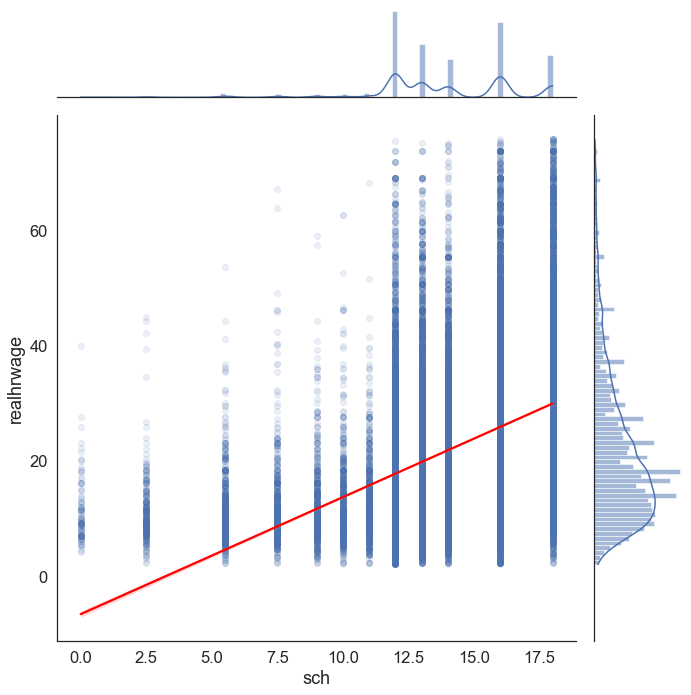

In [ ]:
sns.jointplot(data=reg_df, x='sch', y='realhrwage', kind="reg",  scatter_kws=dict(alpha=0.1), line_kws=dict(color='red'), height=10)



We can more thoroughly diagnose heteroscedasticity *after* having run our regression models, since we have access to the model's **residuals** (the difference between the observed values and the predicted values). Remember, one of the assumptions of linear regression is that the residuals are normally distributed. A Quantile-Quantile Plot (Q-Q Plot) is a plot of the quantiles of a sample against the quantiles of a theoretical distribution. The quantiles are the values that divide the range of a probability distribution into continuous intervals with equal probabilities. Thus, we can use a Q-Q plot to compare the residuals of our model to a normal distribution as follows:

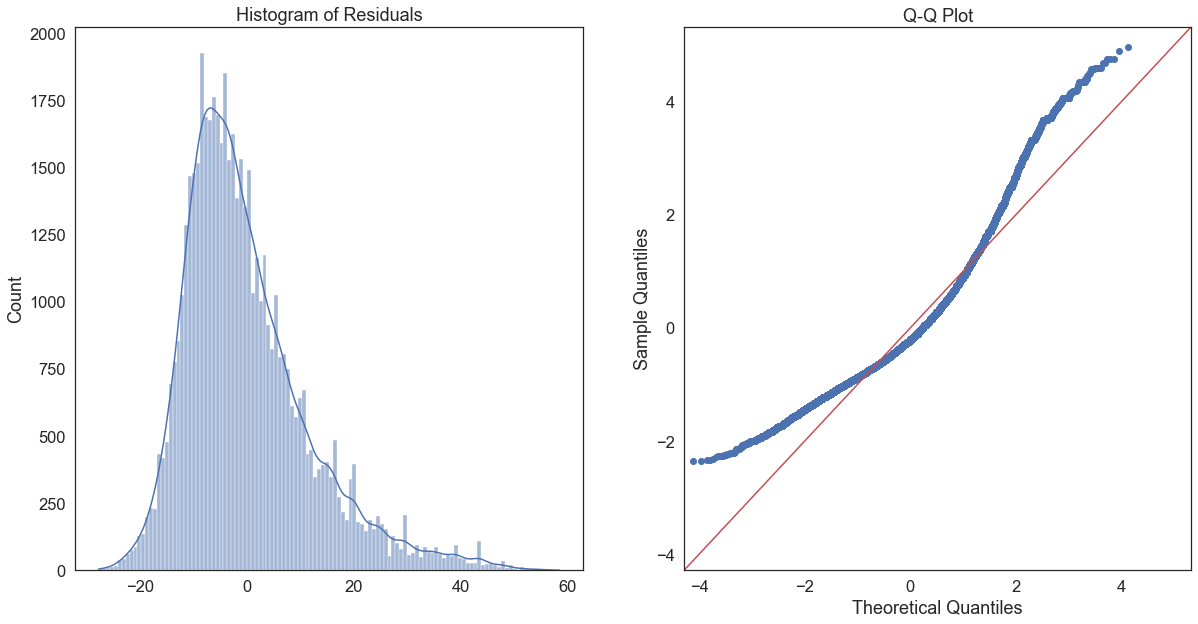

In [ ]:
model = ols('realhrwage ~  sch', data=reg_df).fit()  # fit a model
residuals = model.resid # get the residuals

# make the figure wider
plt.rcParams["figure.figsize"] = [20, 10]

f, axes = plt.subplots(1, 2)
sns.histplot(residuals, kde=True, ax=axes[0]) # plot the residuals
axes[0].set_title('Histogram of Residuals') # add a title

sm.qqplot(residuals, line='45', fit=True,  ax=axes[1]) # plot the residuals
axes[1].set_title('Q-Q Plot') # add a title

plt.show() # show the plot

This Q-Q plot suggests that our residuals are not normally distributed, as very few of them are on the red line. This is probably due to the fact that the `realhrwage` variable is itself highly skewed.

Log transformations are often recommended for skewed data, such as monetary measures or certain biological and demographic measures. Log transforming data usually has the effect of spreading out clumps of data and bringing together spread-out data. So instead of:

$$Hourly\ Income= \beta_0 + \beta_1 \times Years\ of\ Schooling +\epsilon $$

we get:

$$\log{(Hourly\ Income)}= \beta_0 + \beta_1 \times Years\ of\ Schooling +\epsilon $$

In effect, this means changing our belief that there is a linear relationship between schooling and income (a constant increase in x leads to a constant increase in y across the whole range of x). Qualitatively, this means

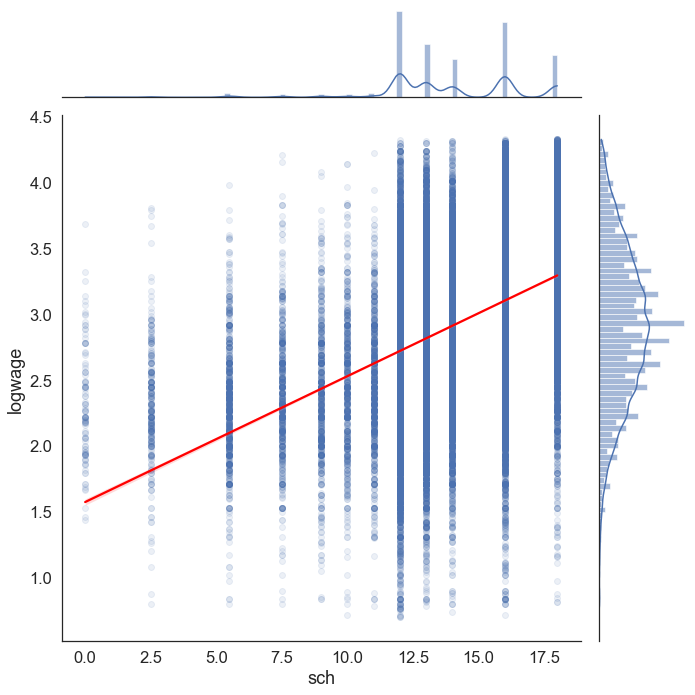

In [ ]:
reg_df['logwage']=np.log(reg_df['realhrwage'])
sns.jointplot(data=reg_df, x='sch', y='logwage', kind="reg",  scatter_kws=dict(alpha=0.1), line_kws=dict(color='red'), height=10)

A few things are noticeably different in this plot. First, the histogram of `logwage` on the far right is a lot less skewed than the histogram of `realhrwage`. Consequently, the regression line seems to fit the data slightly better across the whole range of the data.

We can generate the same residual histogram and Q-Q plot as before, but using a model in which `logwage` is the dependent variable:

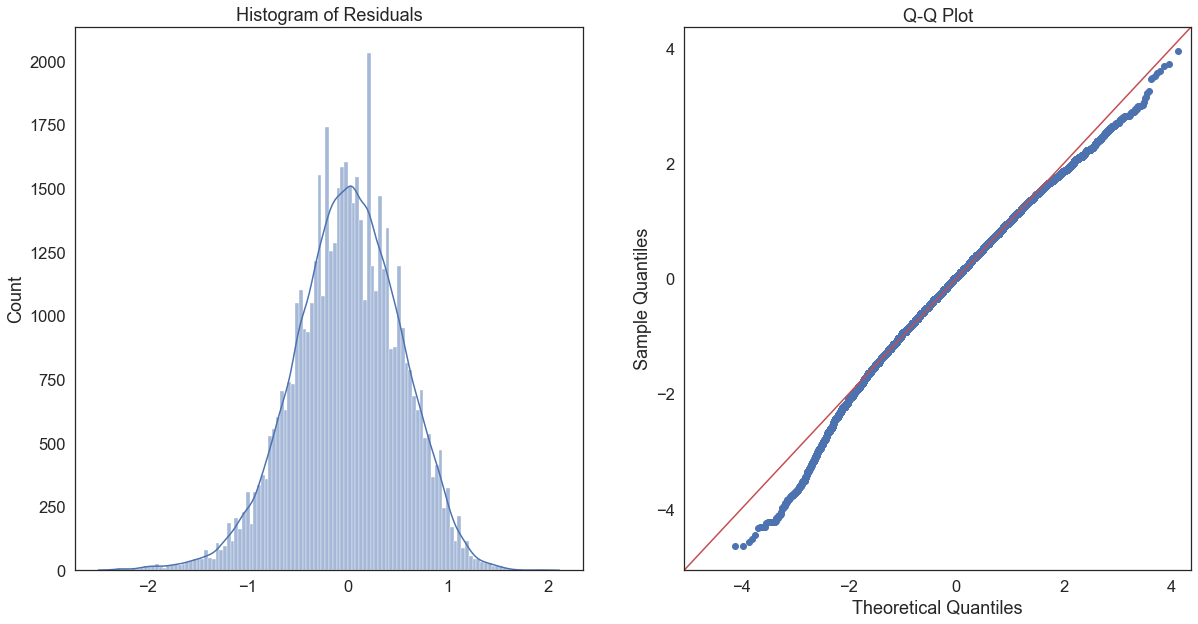

In [ ]:
log_model = ols('logwage ~  sch', data=reg_df).fit()  # fit a model
log_model_residuals = log_model.resid # get the residuals

# make the figure wider
plt.rcParams["figure.figsize"] = [20, 10]

f, axes = plt.subplots(1, 2)
sns.histplot(log_model_residuals, kde=True, ax=axes[0]) # plot the residuals
axes[0].set_title('Histogram of Residuals') # add a title

sm.qqplot(log_model_residuals, line='45', fit=True,  ax=axes[1]) # plot the residuals
axes[1].set_title('Q-Q Plot') # add a title

plt.show() # show the plot

It's not perfect, but it's a lot better than the unlogged version; a large proportion of the residuals fall on the red line in the Q-Q plot, though they diverge at the tips. The histogram of residuals also seems to be less skewed, and more evenly distributed around 0.

## Coefficient interpretation.


Only the dependent/response variable is log-transformed. Exponentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. Here's a [full guide](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/#:~:text=Interpret%20the%20coefficient%20as%20the,variable%20increases%20by%20about%200.20%25.) to interpreting the coefficients on log-transformed variables.

First, let's compare the unlogged and logged models:

In [ ]:
table=summary_col( # create a regression table
    [model,log_model], # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=['Unlogged','Logged'], # set the name of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table)


                Unlogged  Logged 
---------------------------------
Intercept      -6.625*** 1.573***
               (0.266)   (0.012) 
sch            2.033***  0.096***
               (0.019)   (0.001) 
R-squared      0.181     0.191   
R-squared Adj. 0.181     0.191   
N              52750     52750   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Interestingly, we can see that we've also got a 1% increase in $R^2$ just from logging the dependent variable. While the coefficient for schooling can be interpreted normally for the unlogged model (every additional year of schooling leads to a $2.03 increase in hourly wages), this is not the case for the logged model. We can interpret the coefficeint in the logged model as follows:

In [ ]:
b1=log_model.params.sch # get the coefficient for sch
exp_b1=np.exp(b1) # exponentiate the coefficient

pct_change=(exp_b1-1)*100 # multiply by 100 to get the percentage change
print('For every additional year of schooling, log wages increase by {}%'.format(round(pct_change,2)))

For every additional year of schooling, log wages increase by 10.04%


# Assessed Question

Filter the dataframe to only contain people who work in construction, extraction and installation. Compared to those who are covered by a union but not themselves members, what is the difference in log hourly earnings for union members? Is this difference statistically significant?